# Лабораторная работа 10

## Практика TensorFlow 2.x

Выполнил: 6231-010402D, Клионкин Владислав

### Задание

В данной лабораторной работе будет практиковаться материал из лекций по TensorFlow на примере решения задачи классификации изображений из датасета Fashion MNIST.</br>
Fashion MNIST - набор черно-белых изображений размера 28х28, что поделены на 10 классов.</br>
Будет построена с нуля и обучена модель логистической регрессии используя как низкоуровневый API.</br>
</br>
Опционально решение той же задачи нейронной сетью, построенной и обученной с использованием Keras.

0 Базовые операции. 
   - 0.1 Сгенерируйте три непересекающихся гауссовых облака, используя `tf.random`. Визуализируйте их разными цветами, используя matplotlib. 
   - 0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

In [1]:
# INIT
import tensorflow as tf
#import tensorflow_transform as tft

import numpy as np
import matplotlib.pyplot as plt
import keras

from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras.datasets import mnist

%matplotlib inline

In [2]:
tf.__version__

'2.9.1'

In [3]:
# Отображаем список физических устройств, видимых для среды выполнения хоста.
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 0.1 Сгенерируйте три непересекающихся гауссовых облака, используя tf.random. Визуализируйте их разными цветами, используя matplotlib.

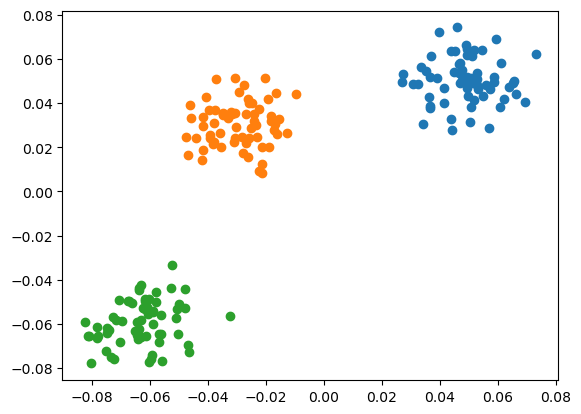

In [4]:
# Для смещения облаков
q = 0.05
a = 0.03
z = 0.06

# Формируем облака 
noise1 = tf.random.normal((64, 2), stddev=0.01) 
noise2 = tf.random.normal((64, 2), stddev=0.01) 
noise3 = tf.random.normal((64, 2), stddev=0.01) 

noise1 = noise1 + np.array([q, q])
noise2 = noise2 + np.array([-a, a])
noise3 = noise3 + np.array([-z, -z])

plt.scatter(noise1[:, 0], noise1[:, 1])
plt.scatter(noise2[:, 0], noise2[:, 1])
plt.scatter(noise3[:, 0], noise3[:, 1])

### 0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

In [6]:
matrix = np.random.normal(size = (2,2))

matrix

array([[ 0.16161311,  1.11102843],
       [-0.47205272,  1.4294963 ]])

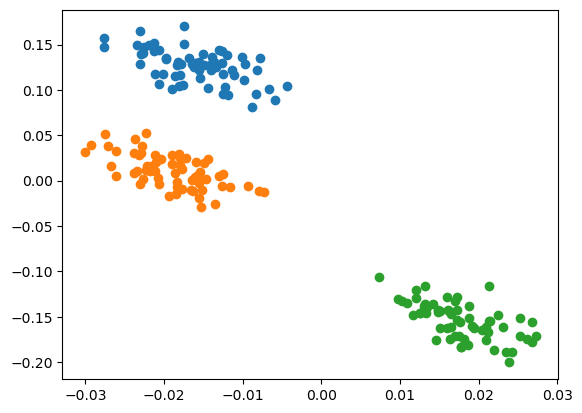

In [7]:
n1_new, n2_new, n3_new = [],[],[]

m_noise1 = tf.matmul(noise1, matrix)
m_noise2 = tf.matmul(noise2, matrix)
m_noise3 = tf.matmul(noise3, matrix)

plt.scatter(m_noise1[:, 0], m_noise1[:, 1])
plt.scatter(m_noise2[:, 0], m_noise2[:, 1])
plt.scatter(m_noise3[:, 0], m_noise3[:, 1])

1 Загрузите датасет Fashion MNIST, используя метод из [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). Визуализируйте несколько изображений, используя библиотеку matplotlib.

11490434/11490434 [==============================] - 5s 0us/step


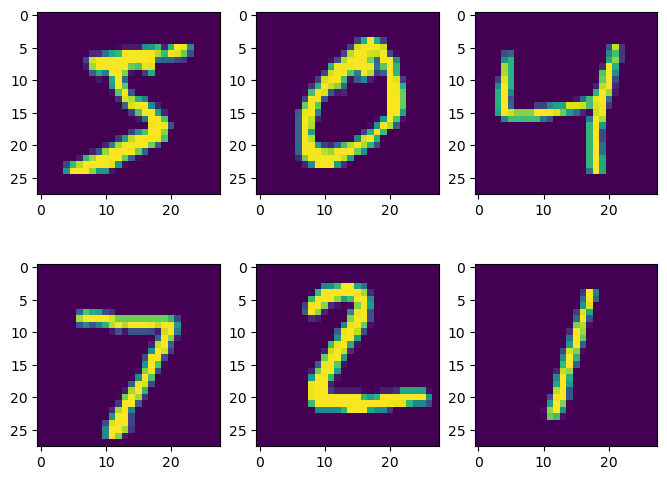

In [8]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

fig, ax = plt.subplots(2, 3, figsize=(8,6))

pcm = ax[0][0].imshow(X_train[0])
pcm = ax[0][1].imshow(X_train[1])
pcm = ax[0][2].imshow(X_train[2])

pcm = ax[1][0].imshow(X_test[0])
pcm = ax[1][1].imshow(X_test[1])
pcm = ax[1][2].imshow(X_test[2])

plt.show()

2 Нормализуйте данные либо средним и СКО, либо приведя значения пикселей в интервал [-1, 1].

In [9]:
X_train = X_train.reshape(60000, -1).astype('float32')
X_test = X_test.reshape(10000, -1).astype('float32')

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [10]:
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean) / (std + 1e-3)
X_test = (X_test - mean) / (std + 1e-3)

3 Создайте обучающий и тестовый TensorFlow Dataset из нормализованного набора данных.</br>
К обучающему датасету добавьте перемешивание (`.shuffle`).</br>
К обоим датасетам добавьте генерацию батчей размера 128 (`.batch(128)`).

In [12]:
batch_size=128

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [14]:
# Вызов методов создаёт новый объект датасета, а не модифицирует исходный!
train_dataset = train_dataset.shuffle(buffer_size=len(X_train), reshuffle_each_iteration=True)

In [15]:
train_dataset = train_dataset.batch(batch_size)

In [16]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

4 Напишите класс слоя `Flatten`, что трансформирует изображения из матричного в векторный вид: [28, 28] -> [28 * 28]. Класс слоя должен наследоваться от `tf.Module`. Для трансформации тензоров изображений использовать `tf.reshape`.

Изображения в DS были уплощены предварительно для оптимизации вычислительных ресурсов

5 Напишите класс линейного слоя `Linear`, что умножает входной вектор на матрицу весов. Класс слоя должен наследоваться от `tf.Module`. Матрицу весов хранить в `tf.Variable`. Параметры конструктора: `in_d` - размерность входного вектора, `out_d` - размерность выходного вектора. В качестве начальной инициализации весов использовать гауссово распределение с СКО=0.01.

In [17]:
#Класс слоя модели 
class Linear(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        # in_d - input dimensionality
        # out_d - output dimensionality
        # В случае с tf.Module вызывать конструктор родительского класса обязательно! 
        super().__init__(name=name)
        w = tf.random.normal(shape=[in_d, out_d], stddev=0.01, dtype='float32')
        self.w = tf.Variable(w, name='linear')
        self.b = tf.Variable(tf.zeros(out_d, dtype='float32'), name='bias')
        
    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b

6 Напишите класс модели логистической регрессии `LogisticRegression`, что компонует в себе слои `Linear` и `Flatten`. Класс модели должен наследоваться от `tf.Module`. В качестве функции активации используйте `tf.nn.softmax`.
Создайте объект модели и попробуйте с помощью неё классифицировать одно изображение (не забудьте о размерности батча! Она будет равна 1).

In [18]:
class LogisticRegression(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        # in_d - input dimensionality
        # out_d - output dimensionality
        super().__init__(name=name)
        linear_name = None
        if name is not None:
            linear_name = name + '_linear'
        self.linear = Linear(in_d, out_d, name=linear_name)
        
    def __call__(self, x):
        x = self.linear(x)
        return tf.nn.softmax(x)

In [19]:
model = LogisticRegression(28*28,10)

In [20]:
preds = model(X_train[0:1])

In [21]:
preds

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.10479791, 0.11364537, 0.1323278 , 0.12298726, 0.080373  ,
        0.08395132, 0.08291027, 0.11546905, 0.0930851 , 0.07045288]],
      dtype=float32)>

In [22]:
tf.argmax(preds, axis=1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([2], dtype=int64)>

7 Напишите функцию оценки точности модели `evaluate`. Список её аргументов: тестовый tf.Dataset, модель. Данная функция будет отличаться оной из лекций тем, что внутри неё не будет ручной выборки батчей из датасета, поскольку tf.Dataset уже делает это за нас.

In [23]:
def accuracy(y_true, y_pred):
    eq = tf.cast(y_true == y_pred, 'float32')
    return tf.reduce_mean(eq)
    
def evaluate(model, ds):
    """
    Функция тестирования модели.
    """
    y_preds = []
    y_test = []
    for x,y in tqdm(ds):
        preds = model(x)
        preds = tf.argmax(preds, axis=-1)
        y_preds.append(preds)
        y_test.append(y)
    
    y_test = tf.concat(y_test, axis=0)
    y_preds = tf.concat(y_preds, axis=0)
    y_preds = tf.cast(y_preds, 'int32')
    
    return accuracy(y_test, y_preds).numpy()

8 Напишите функцию обучающего шага `train_step`. Данная функция будет немного отличаться от показанной в лекции тем, что ей на вход также дается функция ошибки. Полный список аргументов: модель, тупл данных (батч картинок, батч меток), оптимизатор, функция ошибки. Функция `train_step` должна возвращать вычисленное значение функции ошибки.

В данной лабораторной функция ошибки не будет писаться заново, будет использоваться готовая кросс-энтропия из Keras.

In [28]:
def train_step(model, data, optim, criterion):
    """
    Функция, производящая один обучающий шаг.
    """
    with tf.GradientTape() as tape:
        # "Прогон" данных через модель и вычисление значения функции ошибки
        x, y = data
        preds = model(x)
        #print(x, preds,y)
        loss = criterion(y, preds)
    # Вычисление градиентов
    grads = tape.gradient(loss, model.trainable_variables)
    # Применение градиентов к весам
    optim.apply_gradients(zip(grads, model.trainable_variables))
    return loss

9 Оцените точность модели.

In [29]:
acc = evaluate(model, test_dataset)
print('Точность', round(acc * 100, 2), '%')

100%|██████████| 79/79 [00:00<00:00, 1679.35it/s]

Точность 10.42 %


10 Подготовьте гиперпараметры обучения: оптимизатор, функция ошибки ([tf.keras.losses.SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)), количество эпох.

In [30]:
# Гиперпараметры обучения
epochs = 5
print_period = 100

optim = tf.optimizers.Adam(learning_rate=0.005)
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()

11 Напишите обучающий цикл. Цикл состоит из внешнего цикла, что отсчитывает эпохи, и вложенного, что итерируется по обучающему датасету.
Во вложенном цикле должна вызываться функция `train_step`. Каждую эпоху модель должна тестироваться функцией `evaluate`. Должны выводиться номер эпохи, значение ошибки и точности. Сохраняйте значения ошибки и точности в списки. Обучите модель. По ходу обучения подбирайте более оптимальные гиперпараметры обучения (learning_rate, другой оптимизатор).

In [31]:
loss_data = []
acc_data = []
for epoch in range(epochs):
    # Перемешивание данных. Очень часто это позволяет повысить точность модели.
    # Рекомендуется перемешивать данные всегда!
    cnt = 0
    for x,y in tqdm(train_dataset):

        loss = train_step(model, (x,y), optim, cross_entropy)
        
        if cnt % print_period == 0:
            print('Epoch:', epoch, 'Iteration:', cnt, 'Loss:', loss.numpy())
        loss_data.append(loss.numpy())
        cnt += 1
        
    print('Model testing...')
    acc = evaluate(model, test_dataset)
    print('Epoch:', epoch, 'Accuracy:', acc)
    acc_data.append(acc)

 10%|▉         | 45/469 [00:00<00:05, 73.84it/s]

Epoch: 0 Iteration: 0 Loss: 2.3216474


 28%|██▊       | 132/469 [00:01<00:02, 167.45it/s]

Epoch: 0 Iteration: 100 Loss: 0.35888845


 51%|█████     | 240/469 [00:01<00:01, 205.01it/s]

Epoch: 0 Iteration: 200 Loss: 0.52351433


 70%|██████▉   | 328/469 [00:02<00:00, 211.35it/s]

Epoch: 0 Iteration: 300 Loss: 0.42526788


 93%|█████████▎| 438/469 [00:02<00:00, 214.39it/s]

Epoch: 0 Iteration: 400 Loss: 0.50406456


100%|██████████| 469/469 [00:02<00:00, 162.28it/s]


Model testing...


100%|██████████| 79/79 [00:00<00:00, 1679.32it/s]


Epoch: 0 Accuracy: 0.9176


  3%|▎         | 15/469 [00:00<00:03, 144.10it/s]

Epoch: 1 Iteration: 0 Loss: 0.41730762


 31%|███▏      | 147/469 [00:00<00:01, 213.61it/s]

Epoch: 1 Iteration: 100 Loss: 0.3748274


 50%|█████     | 236/469 [00:01<00:01, 216.88it/s]

Epoch: 1 Iteration: 200 Loss: 0.30281


 70%|██████▉   | 327/469 [00:01<00:00, 220.94it/s]

Epoch: 1 Iteration: 300 Loss: 0.4239775


 94%|█████████▍| 440/469 [00:02<00:00, 220.12it/s]

Epoch: 1 Iteration: 400 Loss: 0.43918034


100%|██████████| 469/469 [00:02<00:00, 213.91it/s]


Model testing...


100%|██████████| 79/79 [00:00<00:00, 1679.29it/s]


Epoch: 1 Accuracy: 0.9165


  3%|▎         | 15/469 [00:00<00:03, 149.86it/s]

Epoch: 2 Iteration: 0 Loss: 0.33802462


 28%|██▊       | 130/469 [00:00<00:01, 219.22it/s]

Epoch: 2 Iteration: 100 Loss: 0.22756459


 52%|█████▏    | 242/469 [00:01<00:01, 219.54it/s]

Epoch: 2 Iteration: 200 Loss: 0.35326388


 71%|███████   | 332/469 [00:01<00:00, 220.08it/s]

Epoch: 2 Iteration: 300 Loss: 0.07970251


 90%|█████████ | 424/469 [00:01<00:00, 221.03it/s]

Epoch: 2 Iteration: 400 Loss: 0.23460102


100%|██████████| 469/469 [00:02<00:00, 215.98it/s]


Model testing...


100%|██████████| 79/79 [00:00<00:00, 1610.76it/s]


Epoch: 2 Accuracy: 0.9156


  3%|▎         | 15/469 [00:00<00:03, 145.50it/s]

Epoch: 3 Iteration: 0 Loss: 0.34976453


 26%|██▋       | 124/469 [00:00<00:01, 201.99it/s]

Epoch: 3 Iteration: 100 Loss: 0.10827843


 49%|████▉     | 229/469 [00:01<00:01, 200.08it/s]

Epoch: 3 Iteration: 200 Loss: 0.39907512


 71%|███████▏  | 335/469 [00:01<00:00, 207.03it/s]

Epoch: 3 Iteration: 300 Loss: 0.32027578


 90%|█████████ | 424/469 [00:02<00:00, 215.58it/s]

Epoch: 3 Iteration: 400 Loss: 0.47754744


100%|██████████| 469/469 [00:02<00:00, 206.10it/s]


Model testing...


100%|██████████| 79/79 [00:00<00:00, 1679.39it/s]


Epoch: 3 Accuracy: 0.9151


  3%|▎         | 14/469 [00:00<00:03, 139.87it/s]

Epoch: 4 Iteration: 0 Loss: 0.36756387


 27%|██▋       | 125/469 [00:00<00:01, 215.83it/s]

Epoch: 4 Iteration: 100 Loss: 0.43781912


 51%|█████     | 239/469 [00:01<00:01, 221.53it/s]

Epoch: 4 Iteration: 200 Loss: 0.24586564


 71%|███████   | 331/469 [00:01<00:00, 222.50it/s]

Epoch: 4 Iteration: 300 Loss: 0.33669955


 95%|█████████▌| 446/469 [00:02<00:00, 223.55it/s]

Epoch: 4 Iteration: 400 Loss: 0.19496644


100%|██████████| 469/469 [00:02<00:00, 216.23it/s]


Model testing...


100%|██████████| 79/79 [00:00<00:00, 1715.86it/s]

Epoch: 4 Accuracy: 0.9186


12 Выведите графики точности и ошибки, используя matplotlib.

In [32]:
v_1 = np.arange(0, len(loss_data), 1)
print(len(v_1))
v_2 = np.arange(0, len(acc_data), 1)
print(len(v_2))

2345
5


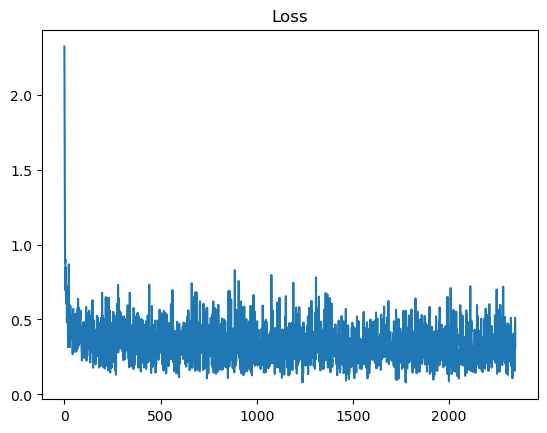

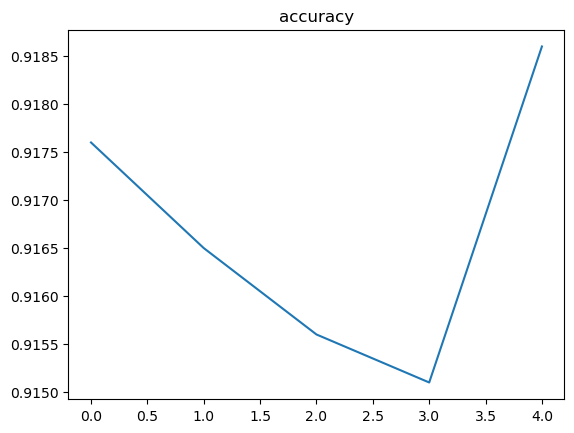

In [33]:
#График лосс и точности модели
plt.plot(v_1,loss_data)
plt.title("Loss")
plt.show()

plt.plot(v_2,acc_data)
plt.title("accuracy")
plt.show()

13 (Опционально) Постройте и обучите произвольную нейронную сеть с использованием Keras для решения той же задачи.

In [52]:
shape_x, shape_y = X_train.shape
shape_y = np.sqrt(shape_y).astype(np.int32)
X_train = X_train.reshape((shape_x, shape_y, shape_y, 1))
X_train.shape

(60000, 28, 28, 1)

In [57]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam, Adagrad

In [58]:
cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(32,activation='relu'),
    Dense(10,activation = 'softplus')
])

cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adagrad(learning_rate=0.01),metrics =['accuracy'])

In [59]:
with tf.device('/gpu:0'):
    history = cnn_model.fit(
        X_train,
        y_train,
        epochs=10,
        verbose=1
    )

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3282 - accuracy: 0.9061
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1461 - accuracy: 0.9562
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1116 - accuracy: 0.9669
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0940 - accuracy: 0.9718
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0812 - accuracy: 0.9749
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0734 - accuracy: 0.9779
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0672 - accuracy: 0.9797
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0625 - accuracy: 0.9814
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0593 - accuracy: 0.9823
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.054

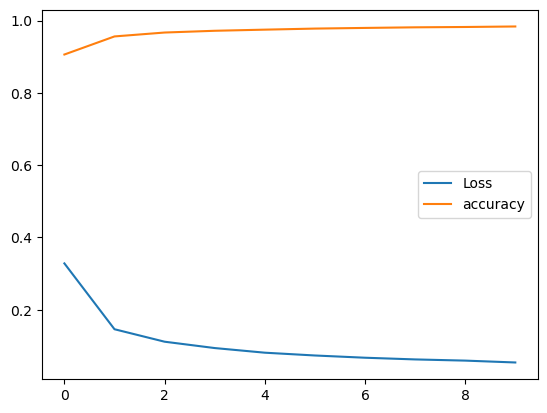

In [60]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["accuracy"], label="accuracy")
plt.legend()